# Predykcja czasu dostawy zamówienia


## Treść zadania
Wygląda na to, że nasze firmy kurierskie czasami nie radzą sobie z dostawami. Gdybyśmy
wiedzieli, ile taka dostawa dla danego zamówienia potrwa – moglibyśmy przekazywać tą
informację klientom.

## Poziom biznesowy

### Zadanie biznesowe
Celem tego projektu jest dodanie przewidywania czasu dostawy dla każdego z zamówień dokonanych przez klientów. Dostarczenie takiej informacji klientom powinno pozytywnie wpłynąć na ich zadowolenie z korzystania z naszego sklepu internetowego. To z kolei sprawi, że częściej będą korzystać z naszych usług.

### Biznesowe kryterium sukcesu
System w dobrym stopniu estymuje czas dostawy dla każdego zamówienia - przekazuje klientowi dokładniejszą informację dla jego zamówienia od średniego czasu dostawy zamówień.

## Poziom analityczny

### Zadanie modelowania
Czas dostawy to wartość ciągła, stąd też problem sprowadza się do zadania regresji.

### Analityczne kryterium sukcesu
Wartość RMSE dla przewidywanego czasu dostawy nie przekracza 5 godzin.

### Założenia
* Model obsługiwać będzie tylko te kategorie produktów, które pojawiają się w danych uczących
* Wszystkie przesyłki mają być dostarczone na terenie Polski. Na etapie modelowania miasta zostaną przekonwertowane na współrzędne. Dzięki temu model będzie działał także dla miast, które nie pojawiły się w danych uczących.

# Wczytanie danych z plików

In [1]:
#installs pandasql within jupyter kernel
%pip install pandasql

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime
import time
import pandas as pd
from pandasql import sqldf

In [3]:
dataPath = "IUM21L_Zad_03_02_v2"

deliveriesFile = open(dataPath + "/deliveries.jsonl", "r")
productsFile = open(dataPath + "/products.jsonl", "r")
sessionsFile = open(dataPath + "/sessions.jsonl", "r")
usersFile = open(dataPath + "/users.jsonl", "r")

deliveries = [json.loads(jline) for jline in deliveriesFile.read().splitlines()]
products = [json.loads(jline) for jline in productsFile.read().splitlines()]
sessions = [json.loads(jline) for jline in sessionsFile.read().splitlines()]
users = [json.loads(jline) for jline in usersFile.read().splitlines()]

print('Deliveries keys:\t', end='')
for key in deliveries[0].keys():
    print(key+"\t", end='')
print("")
print('Products keys:\t\t', end='')
for key in products[0].keys():
    print(key+"\t", end='')
print("")
print('Sessions keys:\t\t', end='')
for key in sessions[0].keys():
    print(key+"\t", end='')
print("")
print('Users keys:\t\t', end='')
for key in users[0].keys():
    print(key+"\t", end='')
print("")

Deliveries keys:	purchase_id	purchase_timestamp	delivery_timestamp	delivery_company	
Products keys:		product_id	product_name	category_path	price	
Sessions keys:		session_id	timestamp	user_id	product_id	event_type	offered_discount	purchase_id	
Users keys:		user_id	name	city	street	


In [4]:
deliveriesDF = pd.DataFrame.from_dict(deliveries)
productsDF = pd.DataFrame.from_dict(products)
sessionsDF = pd.DataFrame.from_dict(sessions)
usersDF = pd.DataFrame.from_dict(users)

In [5]:
pysqldf = lambda q: sqldf(q, globals())
dataDF = pysqldf("SELECT * FROM sessionsDF s JOIN deliveriesDF d ON s.purchase_id = d.purchase_id JOIN productsDF p ON s.product_id = p.product_id JOIN usersDF u ON s.user_id = u.user_id;")
projectedDataDF = pysqldf("SELECT purchase_timestamp, delivery_timestamp, delivery_company, offered_discount, product_name, price, category_path, name, city, street FROM dataDF;")

## Atrybuty w stworzonej z danych pojedynczej tabeli

In [6]:
pysqldf("SELECT * FROM projectedDataDF LIMIT 0;")

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street


# Analiza danych

### Funkcje wykorzystywane do konwersji daty

In [7]:
# Convert date to unix timestamp (seconds only)
def dateToTimestamp(date):
    date = date.split('.')[0]
    date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S").timetuple()
    return time.mktime(date)

def timestampToDate(timestamp):
    return datetime.fromtimestamp(timestamp).strftime("%Y-%m-%dT%H:%M:%S")

### Funkcje pomocnicze - test chi kwadrat

In [8]:
# array - 2D array with 2 columns corresponding to each attribute and rows corresponding to samples
# bins - number of bins to put the first and second attribute into
# if bins[i] == -1 we assume that this attribute is discrete and count each value separately
def chi2(array, bins=[-1, -1]):
    #Calculate value at the beginning of each bin
    binValues = []
    for i in range(2):
        if bins[i] == -1:
            values = array[:, i]
            values = np.unique(values)
            values = np.sort(values)
            binValues.append(values.tolist())
        else:
            maxValue = np.amax(array[:, i])
            minValue = np.amin(array[:, i])
            values = np.linspace(minValue, maxValue, bins[i])
            binValues.append(values.tolist())
            
    #Create the matrix for chi2
    dataMatrix = np.zeros((len(binValues[0]), len(binValues[1])))
    for row in array:
        AbinIndex = sum(i <= row[0] for i in binValues[0])-1
        BbinIndex = sum(i <= row[1] for i in binValues[1])-1
        dataMatrix[AbinIndex][BbinIndex] += 1
    
    #Calculate chi2
    n = np.sum(dataMatrix)
    pi = np.sum(dataMatrix, axis=1)/n
    pj = np.sum(dataMatrix, axis=0)/n
    result = 0
    for i in range(dataMatrix.shape[0]):
        for j in range(dataMatrix.shape[1]):
            pipj = pi[i]*pj[j]
            if dataMatrix[i][j] == 0:
                continue
            result += n*pipj*((dataMatrix[i][j]/n-pipj)/pipj)**2
    return result
            

In [9]:
#Now we test our chi2 function on some sample data
#If the function works correctly, the result for random noise data should be small, whereas the result for fully correlated data should be big

#random noise
df_random_noise = pd.DataFrame(np.random.randint(0,100,size=(10000, 1)), columns=list('A'))
df_random_noise["B"] = 0
for index, _ in df_random_noise.iterrows():
    df_random_noise.at[index, "B"] = np.random.randint(2)
print("random noise: " + str(chi2(df_random_noise.to_numpy(), [100, -1])))

#full correlation
df_full_correlation = df_random_noise
for index, _ in df_full_correlation.iterrows():
    df_full_correlation.at[index, "B"] = df_full_correlation.at[index, "A"] % 2 #correlation by modulo
print("full correlation: " + str(chi2(df_full_correlation.to_numpy(), [100, -1])))

random noise: 105.43068325051588
full correlation: 5000.115199999999


In [10]:
#Function calling chi2 and returning input parameters and result in a one-row dataframe
def chi2_test(first_column_name, second_column_name, dataframe_name, bins=[-1, -1]):
    data = pysqldf("select " + first_column_name + ", " + second_column_name + " from " + dataframe_name).to_numpy()
    #Change nan values to -1
    data[:, 0] = np.nan_to_num(data[:, 0], nan=-1)
    result = chi2(data, bins)
    return pd.DataFrame([[first_column_name, second_column_name, result]], columns=["first_column_name", "second_column_name", "result"])

In [11]:
#Function performing chi2_test on majority of parameters and constructing a dataframe with results
def constructChi2Table(dataframe, dataframe_name, second_column_name, bin_value):
    chi2_results = pd.DataFrame(columns=["first_column_name", "second_column_name", "result"])
    
    chi2_results = chi2_results.append(chi2_test("city", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    if "purchase_day_name" in dataframe:
        chi2_results = chi2_results.append(chi2_test("purchase_day_name", second_column_name, dataframe_name=dataframe_name,bins=[-1, bin_value]), ignore_index=True)
    if "delivery_day_name" in dataframe:
        chi2_results = chi2_results.append(chi2_test("delivery_day_name", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    chi2_results = chi2_results.append(chi2_test("category_path", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    chi2_results = chi2_results.append(chi2_test("delivery_company", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    chi2_results = chi2_results.append(chi2_test("offered_discount", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    chi2_results = chi2_results.append(chi2_test("price", second_column_name, dataframe_name=dataframe_name, bins=[100, bin_value]), ignore_index=True)
    
    #for full correlations
    if "delivery_time_h" in dataframe:
        chi2_results = chi2_results.append(chi2_test("delivery_time_h", second_column_name, dataframe_name=dataframe_name, bins=[100, bin_value]), ignore_index=True)
    if "is_delivery_after_purchase" in dataframe:
        chi2_results = chi2_results.append(chi2_test("is_delivery_after_purchase", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    if "is_price_correct" in dataframe:
        chi2_results = chi2_results.append(chi2_test("is_price_correct", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    if "is_delivered" in dataframe:
        chi2_results = chi2_results.append(chi2_test("is_delivered", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)
    if "is_delivery_company" in dataframe:
        chi2_results = chi2_results.append(chi2_test("is_delivery_company", second_column_name, dataframe_name=dataframe_name, bins=[-1, bin_value]), ignore_index=True)

    return chi2_results


# Braki i błędy danych

## Przesyłki dostarczone przed zamówieniem
W wielu przypadkach w danych zdarza się, że moment zakupu wypada później od momentu dostarczenia zakupionego produktu, co nie powinno mieć miejsca. Poniżej wyznaczamy liczbę tych przypadków, a w kolejnej sekcji przedstawiamy dokładne różnice między czasami dostawy i zakupu zamówienia. Opisana sytuacja widoczna jest tam jako ujemny czas dostawy.

In [12]:
pysqldf("SELECT count(*) as 'Dostarczone przed zakupem' FROM projectedDataDF WHERE purchase_timestamp > delivery_timestamp;")

,Dostarczone przed zakupem
0,0


### Czas dostawy wszystkich dostarczonych przesyłek

Czas dostawy przesyłek rozłożony jest równomiernie wokół średniego czasu dostawy równego ok. 25 godzin. Rozkład ten nie odpowiada oczekiwanemu rozkładowi czasów dostawy i zawiera dużą część błędnych, ujemnych wartości.

0 purchases not delivered
7287 purchases delivered


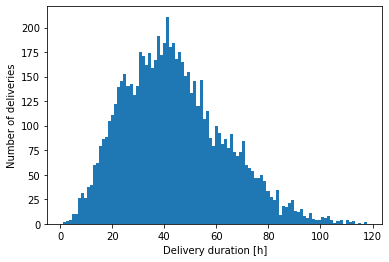

Mean delivery duration: 43.7555204854916


In [13]:
notDeliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is None]
deliveredList = [delivery for delivery in deliveries if delivery['delivery_timestamp'] is not None]
print(str(len(notDeliveredList))+" purchases not delivered")
print(str(len(deliveredList))+" purchases delivered")

deliveryTimes = [dateToTimestamp(delivery['delivery_timestamp']) for delivery in deliveredList]
purchaseTimes = [dateToTimestamp(delivery['purchase_timestamp']) for delivery in deliveredList]

deliveryDurations = [(deliveryTime - purchaseTime)/3600 for deliveryTime, purchaseTime in zip(deliveryTimes, purchaseTimes)]

plt.hist(deliveryDurations, density=False, bins=100)
plt.ylabel('Number of deliveries')
plt.xlabel('Delivery duration [h]')
plt.show()

print("Mean delivery duration: " + str(sum(deliveryDurations)/len(deliveryDurations)))

### Czas dostawy wszystkich dostarczonych przesyłek z podziałem na firmy kurierskie

Rozkłady czasu dostawy dla poszczególnych firm kurierskich nie są wyraźnie od siebie różne, wszystkie zawierają błędne, ujemne wartości czasu dostawy.

Company 620
2483 deliveries
Mean delivery duration: 43.26587483778587


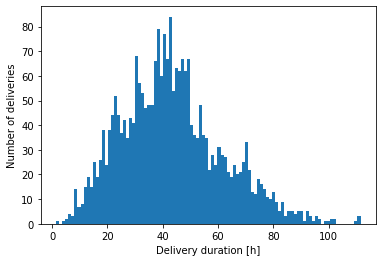

Company 360
2359 deliveries
Mean delivery duration: 47.23985410484661


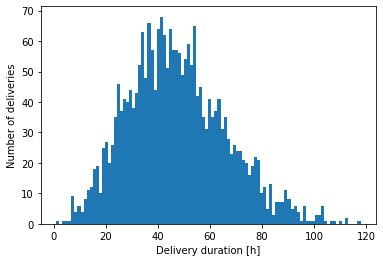

Company 516
2445 deliveries
Mean delivery duration: 40.89099988638948


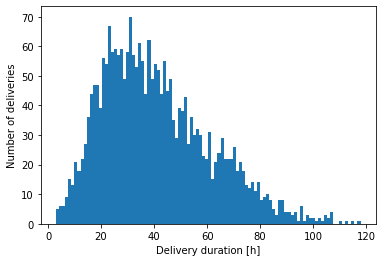

In [14]:
companies = []
for delivery in deliveries:
    if delivery['delivery_company'] not in companies:# and delivery['delivery_company'] is not None:
        companies.append(delivery['delivery_company'])

for company in companies:
    print('Company '+str(company))
    durations = []
    counter = 0
    for delivery in deliveredList:
        if delivery['delivery_company'] == company:
            counter += 1
            durations.append((dateToTimestamp(delivery['delivery_timestamp']) - dateToTimestamp(delivery['purchase_timestamp']))/3600)
    print(str(counter)+' deliveries')
    print("Mean delivery duration: " + str(sum(durations)/len(durations)))
    plt.hist(durations, density=False, bins=100)
    plt.ylabel('Number of deliveries')
    plt.xlabel('Delivery duration [h]')
    plt.show()

### Błąd zbyt wczesnej dostawy
W tej sekcji sprawdzamy, czy jest jakaś zależność pomiędzy zbyt wczesnym czasem dostawy (przed zakupem) a innymi atrybutami.

In [15]:
#First we have to transform our data - note that we choose dataframe containing all original rows

noDeliveryNullsDataDF = pysqldf("SELECT * FROM projectedDataDF WHERE delivery_timestamp IS NOT NULL")

#create column informing about error
noDeliveryNullsDataDF["is_delivery_after_purchase"] = 1


for index, _ in noDeliveryNullsDataDF.iterrows():
    if noDeliveryNullsDataDF["purchase_timestamp"].iloc[index] > noDeliveryNullsDataDF["delivery_timestamp"].iloc[index]:
        noDeliveryNullsDataDF.at[index, "is_delivery_after_purchase"] = 0

In [16]:
constructChi2Table(noDeliveryNullsDataDF, "noDeliveryNullsDataDF", second_column_name="is_delivery_after_purchase", bin_value=-1)

,first_column_name,second_column_name,result
0,city,is_delivery_after_purchase,0.0
1,category_path,is_delivery_after_purchase,0.0
2,delivery_company,is_delivery_after_purchase,0.0
3,offered_discount,is_delivery_after_purchase,0.0
4,price,is_delivery_after_purchase,0.0
5,is_delivery_after_purchase,is_delivery_after_purchase,0.0


Nie widać żadnej wyraźnej zależności pomiędzy zbyt wczesnym czasem dostawy a innymi parametrami. Wnioskujemy stąd, że błąd ten jest niezależny od innych atrybutów i w dalszej analizie usuwamy nieprawidłowe rekordy.

## Ceny produktów

Atrybut ten zawiera elementy odstające - występują ceny ujemne oraz bardzo duże. W kodzie poniżej używamy wartości 100000 jako największej realnej ceny, jednak w przefiltrowanych, realnych danych nie ma cen większych od 10000.

In [17]:
products.sort(key=lambda product : product["price"])

maxPossiblePrice = 100000
priceOutlierProducts = [product for product in products if product["price"] < 0 or product["price"] > maxPossiblePrice]
priceInliers = [product["price"] for product in products if product["price"] >= 0 and product["price"] <= maxPossiblePrice]

print("Lowest price: "+str(priceInliers[0]))
print("Highest price: "+str(priceInliers[-1]))
print("Inliers: "+str(len(priceInliers)))
print("")
print("Outliers: "+str(len(priceOutlierProducts)))
print("Price\tProduct")
for product in priceOutlierProducts:
    print(str(product["price"])+"\t"+str(product["product_name"]))

Lowest price: 1.0
Highest price: 7639.0
Inliers: 319

Outliers: 0
Price	Product


W kolejnej sekcji sprawdzamy, czy jest jakaś zależność pomiędzy błędną ceną a innymi atrybutami.

In [18]:
#First we have to transform our data - note that we choose dataframe containing all original rows

min_price = 0
max_price = 10**5

#create column informing about error
projectedDataDF["is_price_correct"] = 1


for index, _ in projectedDataDF.iterrows():
    current_price = projectedDataDF["price"].iloc[index]
    if current_price > max_price or current_price < min_price:
        projectedDataDF.at[index, "is_price_correct"] = 0

In [19]:
constructChi2Table(projectedDataDF, "projectedDataDF", second_column_name="is_price_correct", bin_value=-1)

,first_column_name,second_column_name,result
0,city,is_price_correct,0.0
1,category_path,is_price_correct,0.0
2,delivery_company,is_price_correct,0.0
3,offered_discount,is_price_correct,0.0
4,price,is_price_correct,0.0
5,is_price_correct,is_price_correct,0.0


W powyższej tabeli widać 2 zależności błędnej ceny: od samej ceny (to oczywiste, zależność tą możemy zignorować) i od kategorii produktu. Tej drugiej zależności nie możemy zignorować - stawiamy zatem hipotezę, że nieprawidłowa cena uzależniona jest od kategorii produktu. W poprzedniej sekcji, w której wypisane zostały produkty, których ceny są elementami odstającymi, widać, że większość produktów z nieprawidłowymi cenami to w istocie elementy jednej kategorii - gry komputerowe.

W celu głębszej analizy tego problemu zliczamy wszystkie produkty oraz elementy odstające w każdej z kategorii.

In [20]:
outliersDict = {}
categoriesDict = {}
for product in products:
    outliersDict[product["category_path"]] = 0
    categoriesDict[product["category_path"]] = 0
for product in products:
    categoriesDict[product["category_path"]] += 1
for product in priceOutlierProducts:
    outliersDict[product["category_path"]] += 1

priceOutliersDF = pd.DataFrame(columns=["Category", "Percent of price errors [%]", "Number of products"])
for key in categoriesDict.keys():
    row = pd.DataFrame([[key, outliersDict[key]/categoriesDict[key], categoriesDict[key]]], columns=["Category", "Percent of price errors [%]", "Number of products"])
    priceOutliersDF = priceOutliersDF.append(row, ignore_index=True)
print(priceOutliersDF)

                                             Category  \
0                       Gry i konsole;Gry komputerowe   
1           Gry i konsole;Gry na konsole;Gry Xbox 360   
2   Telefony i akcesoria;Akcesoria telefoniczne;Ze...   
3   Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...   
4           Telefony i akcesoria;Telefony stacjonarne   
5       Gry i konsole;Gry na konsole;Gry PlayStation3   
6   Sprzęt RTV;Przenośne audio i video;Odtwarzacze...   
7   Telefony i akcesoria;Akcesoria telefoniczne;Ze...   
8   Sprzęt RTV;Video;Telewizory i akcesoria;Okular...   
9                    Sprzęt RTV;Video;Odtwarzacze DVD   
10            Telefony i akcesoria;Telefony komórkowe   
11                    Komputery;Monitory;Monitory LCD   
12                         Sprzęt RTV;Audio;Słuchawki   
13              Komputery;Tablety i akcesoria;Tablety   
14  Komputery;Drukarki i skanery;Biurowe urządzeni...   

    Percent of price errors [%] Number of products  
0                           0.0   

Okazuje się, że około 2/3 produktów w sklepie to gry komputerowe. Względna liczba elementów odstających w tej kategorii jest taka sama, jak ogólna względna liczba elementów odstających wśród wszystkich produktów i stanowi ok. 10% elementów. Wstępną hipotezę o zależności błędów w cenie od kategorii odrzucamy - wysoki wynik w teście był spowodowany niezbalansowaną liczebnością produktów każdej kategorii.

## Czasy zamówienia niedostarczonych przesyłek

Analizujemy czasy zamówienia przesyłek, które w bazie nie mają oznaczonego czasu dostarczenia zamówienia. Nie wiemy, czy wynika to z faktu rzeczywistego niedostarczenia tych zamówień, czy nie umieszczeniu informacji o dostarczeniu w bazie danych lub innych błędach w danych. Dla różnych przesyłek przyczyny mogły być różne.

Na potrzeby analizy za "dzisiejszą" datę przyjmujemy najpóźniejszy czas dostawy obecny w bazie - przedstawimy czas jaki minął od zakupu niedostarczonych przesyłek do tego momentu.

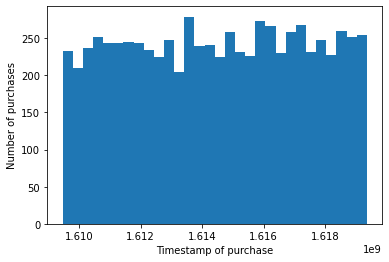

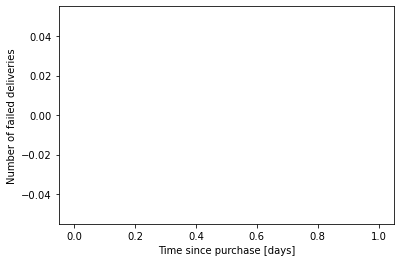

In [21]:
purchasesList = pysqldf("select purchase_timestamp from projectedDataDF where delivery_timestamp is not null")["purchase_timestamp"].to_list()
purchasesList = [dateToTimestamp(purchase) for purchase in purchasesList]
plt.hist(purchasesList, bins=30, density=False)
plt.xlabel("Timestamp of purchase")
plt.ylabel("Number of purchases")
plt.show()

deliveriesArray = pysqldf("select delivery_timestamp from projectedDataDF where delivery_timestamp is not null order by delivery_timestamp desc").to_numpy()
latestDeliveryTimestamp = dateToTimestamp(deliveriesArray[0][0])

notDeliveredDF = pysqldf("SELECT purchase_timestamp FROM projectedDataDF WHERE delivery_timestamp is null order by purchase_timestamp")
notDeliveredList = notDeliveredDF["purchase_timestamp"].to_list()
waitingTimes = [(latestDeliveryTimestamp - dateToTimestamp(purchase))/(24*3600) for purchase in notDeliveredList]
plt.hist(waitingTimes, bins=30, density=False)
plt.xlabel("Time since purchase [days]")
plt.ylabel("Number of failed deliveries")
plt.show()

Pierwszy histogram pokazuje, że rozkład złożonych zamówień w czasie był w przybliżeniu jednostajny.

Przy założeniu, że braki w czasie dostawy wynikają z niedostarczenia przesyłki: z drugiego histogramu widać, że podobna liczba zamówień z przed prawie 3 miesięcy, jak i tych opłaconych kilka dni temu, nie została dostarczonych. Jako że liczba wszystkich zamówień nie zmieniała się w czasie, część niedostarczonych zamówień nie zależała od czasu zamówienia.

### Błąd niedostarczonej przesyłki
W tej sekcji sprawdzamy, czy jest jakaś zależność pomiędzy brakiem czasu dostarczenia a innymi atrybutami.

In [22]:
#First we have to transform our data - note that we choose dataframe containing all original rows

#create column informing about error
projectedDataDF["is_delivered"] = 1

for index, _ in projectedDataDF.iterrows():
    if projectedDataDF["delivery_timestamp"].iloc[index] is None:
        projectedDataDF.at[index, "is_delivered"] = 0

In [23]:
constructChi2Table(projectedDataDF, "projectedDataDF", second_column_name="is_delivered", bin_value=-1)

,first_column_name,second_column_name,result
0,city,is_delivered,0.0
1,category_path,is_delivered,0.0
2,delivery_company,is_delivered,0.0
3,offered_discount,is_delivered,0.0
4,price,is_delivered,0.0
5,is_price_correct,is_delivered,0.0
6,is_delivered,is_delivered,0.0


Wygląda na to, że niedostarczenie przesyłki od niczego nie zależy. Uznajemy to za błąd MCAR, a same nieprawidłowe rekordy możemy usunąć - nawet jeśli przesyłki nie zostały dostarczone w rzeczywistości, nie jestesmy w stanie tego przewidywać na podstawie danych.

### Błąd braku firmy kurierskiej
W tej sekcji sprawdzamy, czy jest jakaś zależność pomiędzy brakiem firmy kurierskiej dla danego zamówienia a innymi atrybutami.

In [24]:
#First we have to transform our data - note that we choose dataframe containing all original rows

#create column informing about error
projectedDataDF["is_delivery_company"] = 1

for index, _ in projectedDataDF.iterrows():
    if pd.isnull(projectedDataDF.at[index, "delivery_company"]):
        projectedDataDF.at[index, "is_delivery_company"] = 0

In [25]:
constructChi2Table(projectedDataDF, "projectedDataDF", second_column_name="is_delivery_company", bin_value=-1)

,first_column_name,second_column_name,result
0,city,is_delivery_company,0.0
1,category_path,is_delivery_company,0.0
2,delivery_company,is_delivery_company,0.0
3,offered_discount,is_delivery_company,0.0
4,price,is_delivery_company,0.0
5,is_price_correct,is_delivery_company,0.0
6,is_delivered,is_delivery_company,0.0
7,is_delivery_company,is_delivery_company,0.0


Widzimy tu oczywistą zależność pomiędzy obecnością błędu w polu firmy kurierskiej a firmą kurierską. Poza tym nie ma żadnych zależności, stąd to też wygląda na błąd MCAR.

# Analiza czasu dostawy

W tej sekcji przechodzimy do analizy czasu dostawy. Skupiamy się wyłącznie na analizie przesyłek z oznaczoną datą dostarczenia wypadającą później od oznaczonej daty zakupu - pozostałe rekordy usuwamy, jako że uznaliśmy błędy za niezależne od innych atrybutów.

W pierwszej kolejności tworzymy nowy dataframe zawierający poprawne rekordy z oryginalnych danych, z kilkoma dodanymi przez nas kolumnami.

In [26]:
N_SECONDS = 3600.0

correctDataDF = pysqldf("SELECT * FROM projectedDataDF WHERE purchase_timestamp < delivery_timestamp")

#create columns
correctDataDF["purchase_timestamp_sec"] = 0
correctDataDF["delivery_timestamp_sec"] = 0
correctDataDF["delivery_time_h"] = 0.0
correctDataDF["purchase_day_name"] = ""
correctDataDF["delivery_day_name"] = ""

for index, _ in correctDataDF.iterrows():
    correctDataDF.at[index, "purchase_timestamp_sec"] = dateToTimestamp(correctDataDF["purchase_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_timestamp_sec"] = dateToTimestamp(correctDataDF["delivery_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_time_h"] = float(correctDataDF["delivery_timestamp_sec"].iloc[index] - correctDataDF["purchase_timestamp_sec"].iloc[index]) / N_SECONDS
    correctDataDF.at[index, "purchase_timestamp"] = pd.to_datetime(correctDataDF["purchase_timestamp"].iloc[index])
    correctDataDF.at[index, "delivery_timestamp"] = pd.to_datetime(correctDataDF["delivery_timestamp"].iloc[index])
    correctDataDF.at[index, "purchase_day_name"] = correctDataDF["purchase_timestamp"].iloc[index].day_name()
    correctDataDF.at[index, "delivery_day_name"] = correctDataDF["delivery_timestamp"].iloc[index].day_name()

correctDataDF

,purchase_timestamp,delivery_timestamp,delivery_company,offered_discount,product_name,price,category_path,name,city,street,is_price_correct,is_delivered,is_delivery_company,purchase_timestamp_sec,delivery_timestamp_sec,delivery_time_h,purchase_day_name,delivery_day_name
0,2021-04-01 15:52:47,2021-04-02 14:06:34.432964,620,0,Sony DVP-SR760,193.00,Sprzęt RTV;Video;Odtwarzacze DVD,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1,1,1,1617285167,1617365194,22.229722,Thursday,Friday
1,2021-04-01 02:26:23,2021-04-02 10:45:27.707128,360,15,Philips SDV5225,129.00,Sprzęt RTV;Video;Telewizory i akcesoria;Anteny...,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1,1,1,1617236783,1617353127,32.317778,Thursday,Friday
2,2021-01-03 05:11:17,2021-01-04 15:43:07.635371,620,0,Kinect Joy Ride (Xbox 360),69.00,Gry i konsole;Gry na konsole;Gry Xbox 360,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1,1,1,1609647077,1609771387,34.530556,Sunday,Monday
3,2021-02-17 12:59:54,2021-02-18 11:52:42.608746,620,5,Telefon Siemens Gigaset DA310,58.97,Telefony i akcesoria;Telefony stacjonarne,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1,1,1,1613563194,1613645562,22.880000,Wednesday,Thursday
4,2021-02-13 09:17:52,2021-02-15 08:59:28.973167,620,5,Doom 3 (PC),19.99,Gry i konsole;Gry komputerowe,Aurelia Malon,Police,pl. Brzoskwiniowa 11/53,1,1,1,1613204272,1613375968,47.693333,Saturday,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7282,2021-04-15 13:00:45,2021-04-16 08:00:40.223545,516,5,Manta DVD064,109.00,Sprzęt RTV;Video;Odtwarzacze DVD,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1,1,1,1618484445,1618552840,18.998611,Thursday,Friday
7283,2021-01-28 09:32:38,2021-01-29 14:26:03.596544,360,20,Kyocera FS-3540MFP,5126.00,Komputery;Drukarki i skanery;Biurowe urządzeni...,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1,1,1,1611822758,1611926763,28.890278,Thursday,Friday
7284,2021-03-22 20:30:58,2021-03-24 08:26:34.660190,620,10,Szalone Króliki Na żywo i w kolorze (Xbox 360),49.99,Gry i konsole;Gry na konsole;Gry Xbox 360,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1,1,1,1616441458,1616570794,35.926667,Monday,Wednesday
7285,2021-02-19 03:55:11,2021-02-20 18:26:44.646625,620,15,HTC HS-S200,14.99,Telefony i akcesoria;Akcesoria telefoniczne;Ze...,Sara Nóżka,Warszawa,aleja Słoneczna 78/05,1,1,1,1613703311,1613842004,38.525833,Friday,Saturday


W kolejnych sekcjach analizujemy zależności czasu dostawy od innych atrybutów.

### Czas dostawy z podziałem na miasta

In [27]:
correctDataDF.groupby("city").agg(
    count_city=("city", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_city,mean_delivery_time_h,std_delivery_time_h
city,,,
Szczecin,1103,25.161964,11.948112
Police,1216,35.456396,12.884482
Warszawa,992,36.925891,14.708408
Radom,894,41.675921,14.767768
Kutno,628,44.031855,13.507617
Gdynia,824,49.386536,12.739128
Konin,958,56.258659,12.408528
Mielec,672,77.152963,12.547553


Jak widać, czas dostawy nie zależy zbytnio od miasta, w którym znajduje się klient. Być może oznacza to, że firma ma oddziały we wszystkich tych miastach.

### Czas dostawy z podziałem na dni tygodnia - dzień zakupu

In [28]:
correctDataDF.groupby("purchase_day_name").agg(
    count_purchase_day_name=("purchase_day_name", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_purchase_day_name,mean_delivery_time_h,std_delivery_time_h
purchase_day_name,,,
Tuesday,982,39.462448,17.269073
Monday,977,40.286005,17.209155
Sunday,1042,40.901769,16.710076
Wednesday,995,41.061294,18.614951
Thursday,1082,44.201361,23.047181
Saturday,1105,49.178754,13.215186
Friday,1104,49.901178,23.441842


Czas dostawy nie zależy też od dnia tygodnia, w którym dokonano zakupu.

### Czas dostawy z podziałem na dni tygodnia - dzień dostawy

In [29]:
correctDataDF.groupby("delivery_day_name").agg(
    count_delivery_day_name=("delivery_day_name", "count")
).sort_values(by="count_delivery_day_name")

,count_delivery_day_name
delivery_day_name,
Thursday,946
Wednesday,1002
Tuesday,1024
Friday,1061
Saturday,1088
Monday,2166


Tu również nie widać zależności - nasi kurierzy działają równie sprawnie w weekendy jak i w pozostałe dni tygodnia.

### Czas dostawy z podziałem na kategorię produktu

In [30]:
correctDataDF.groupby("category_path").agg(
    count_category_path=("category_path", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_category_path,mean_delivery_time_h,std_delivery_time_h
category_path,,,
Sprzęt RTV;Video;Odtwarzacze DVD,456,42.389928,19.447155
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy głośnomówiące,496,42.490228,18.270522
Sprzęt RTV;Audio;Słuchawki,538,42.727936,19.418878
Gry i konsole;Gry na konsole;Gry Xbox 360,532,42.803449,17.815275
Sprzęt RTV;Przenośne audio i video;Odtwarzacze mp3 i mp4,472,42.934293,18.565299
Sprzęt RTV;Video;Telewizory i akcesoria;Okulary 3D,437,42.946573,18.620026
Telefony i akcesoria;Akcesoria telefoniczne;Zestawy słuchawkowe,479,43.467363,19.412277
Gry i konsole;Gry komputerowe,536,43.641991,18.160207
Komputery;Drukarki i skanery;Biurowe urządzenia wielofunkcyjne,489,43.763366,19.190058


Widać pewną zależność między kategorią produktu a czasem dostawy, jednak nie jest ona bardzo wyraźna.

### Czas dostawy z podziałem na firmy kurierskie

In [31]:
correctDataDF.groupby("delivery_company").agg(
    count_delivery_company=("delivery_company", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_delivery_company,mean_delivery_time_h,std_delivery_time_h
delivery_company,,,
516,2445,40.891000,20.293299
620,2483,43.265875,18.139645
360,2359,47.239854,18.844272


Z powyższej analizy wynika, że wybór firmy kurierskiej nie wpływa znacznie na czas dostawy.

### Czas dostawy z podziałem na udzieloną promocję

In [32]:
correctDataDF.groupby("offered_discount").agg(
    count_offered_discount=("offered_discount", "count"),
    mean_delivery_time_h=("delivery_time_h", "mean"),
    std_delivery_time_h=("delivery_time_h", "std")
).sort_values(by="mean_delivery_time_h")

,count_offered_discount,mean_delivery_time_h,std_delivery_time_h
offered_discount,,,
5,747,42.855095,19.030342
15,727,42.883581,18.618014
10,746,43.342494,18.336273
0,4340,43.998882,19.500774
20,727,44.523675,19.830715


Oferowana zniżka też w żaden wyraźny sposób nie wpływa na czas dostawy.

## Czas dostawy - pora dnia

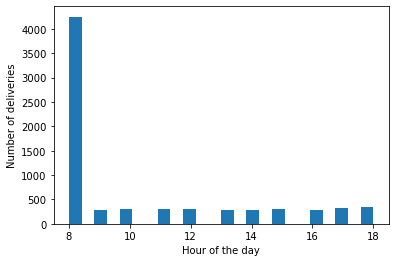

In [33]:
delivery_hours = []

for index, _ in correctDataDF.iterrows():
    delivery_hours.append(correctDataDF["delivery_timestamp"].iloc[index].hour)

plt.hist(delivery_hours, bins=24, density=False)
plt.xlabel("Hour of the day")
plt.ylabel("Number of deliveries")
plt.show()

Firmy kurierskie pracują przez całą dobę.

## Zależności pomiędzy danymi wejściowymi a przewidywaną długością dostawy

In [34]:
constructChi2Table(correctDataDF, "correctDataDF", second_column_name="delivery_time_h", bin_value=100)

,first_column_name,second_column_name,result
0,city,delivery_time_h,5800.591103
1,purchase_day_name,delivery_time_h,2460.597345
2,delivery_day_name,delivery_time_h,978.997845
3,category_path,delivery_time_h,1222.494508
4,delivery_company,delivery_time_h,426.355416
5,offered_discount,delivery_time_h,326.774898
6,price,delivery_time_h,1771.817855
7,delivery_time_h,delivery_time_h,699681.454508
8,is_price_correct,delivery_time_h,0.000000
9,is_delivered,delivery_time_h,0.000000


Test chi2 również wskazuje na to, że nie ma żadnych wyraźnych zależności pomiędzy danymi wejściowymi a przewidywaną długością dostawy.

# Wnioski
Dane, które otrzymaliśmy do analizy nie nadają się do przygotowania skutecznego modelu, który spełniłby zarówno analityczne, jak i biznesowe kryterium sukcesu. Brakuje jakichkolwiek wyraźnych zależności pomiędzy atrybutami a przewidywaną wartością. W danych występuje również wiele błędów, w szczególności błąd dotyczący ujemnych czasów dostawy, który wymaga wyjaśnienia przed kontynuacją prac.

W związku z powyższym wnioskujemy o dostarczenie nowej porcji danych.